In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from imblearn.over_sampling import RandomOverSampler

import copy

import seaborn as sns

# Data Cleaning

In [ ]:
dataset_cols = [
    "Date",
    "Rented Bikes",
    "Hour",
    "Temperature",
    "Humidity",
    "Wind speed",
    "Visibility",
    "Dew_PTemp",
    "Solar Radiation",
    "Rainfall",
    "Snowfall",
    "Seasons",
    "Holiday",
    "Functioning Day"
]
df = pd.read_csv("SeoulBikeData.csv")

In [ ]:
df.columns = dataset_cols

df = df.drop(["Date"], axis = 1) #this proceeds the target, thus creating a coding headache and isn't good data regardless, since it basically functions as a Primary Key

season_mapping = {"Spring": 1, "Summer": 2, "Autumn": 3, "Winter": 4}
df["Seasons"] = df["Seasons"].map(season_mapping).astype(int) #fancy Seasons to Numbers

df["Functioning Day"] = (df["Functioning Day"] == "Yes").astype(int) # do the same thing we did with g and h in the teloscope binary conversion
df["Holiday"] = (df["Holiday"] == "Holiday").astype(int) #


df = df[df["Functioning Day"] == 1] # and on a functioning day
df = df.drop(["Functioning Day"], axis = 1)

In [ ]:
df.head()

,Rented Bikes,Hour,Temperature,Humidity,Wind speed,Visibility,Dew_PTemp,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,4,0
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,4,0
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,4,0
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,4,0
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,4,0


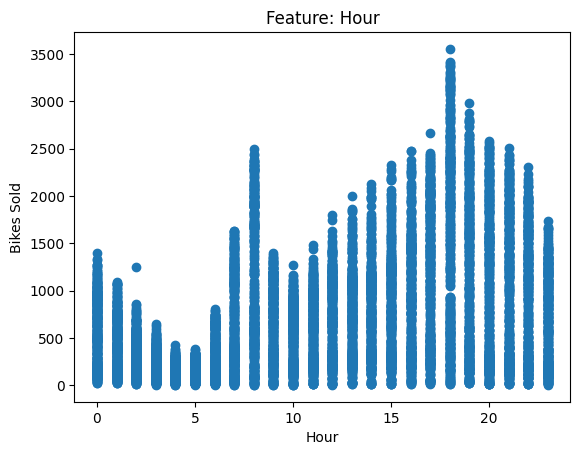

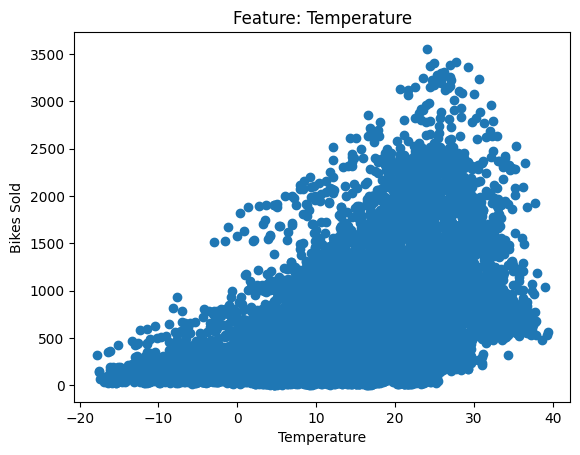

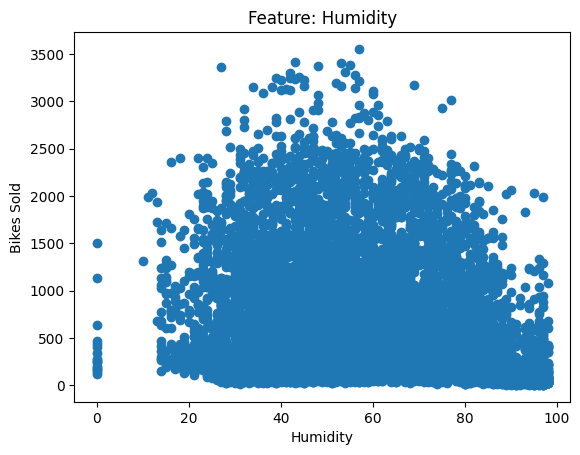

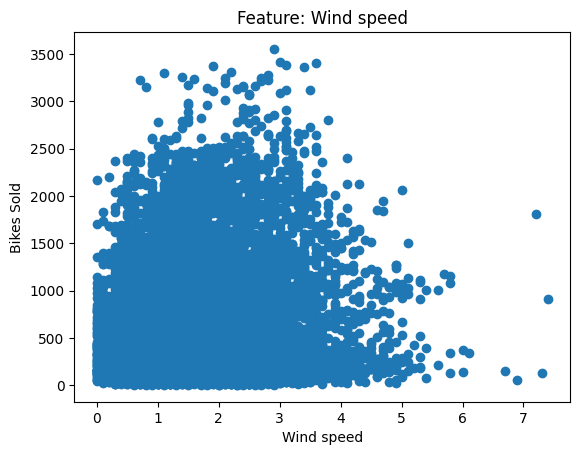

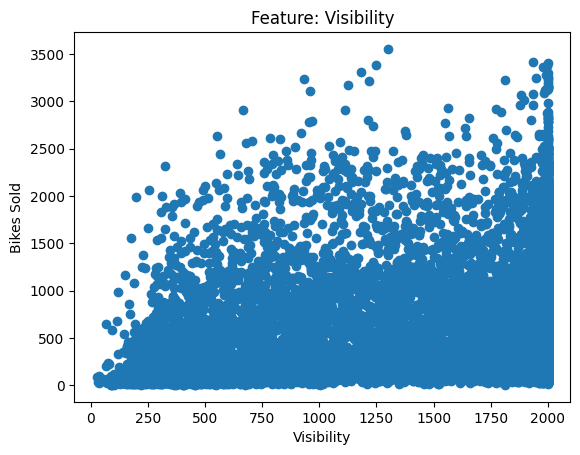

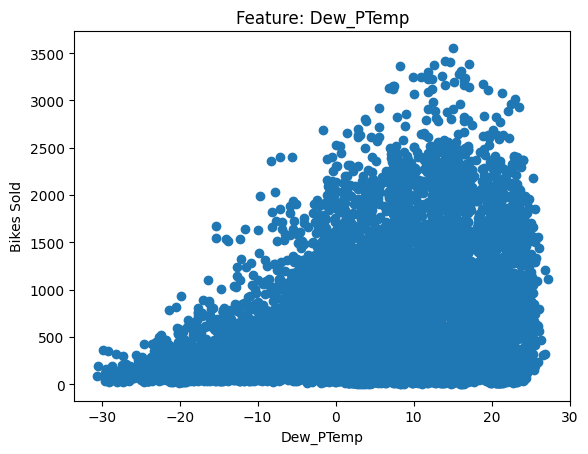

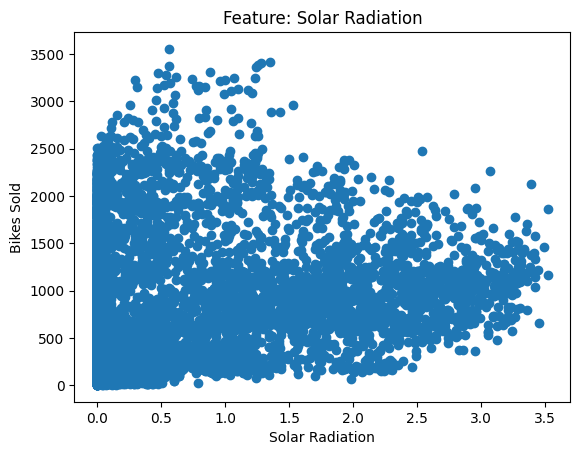

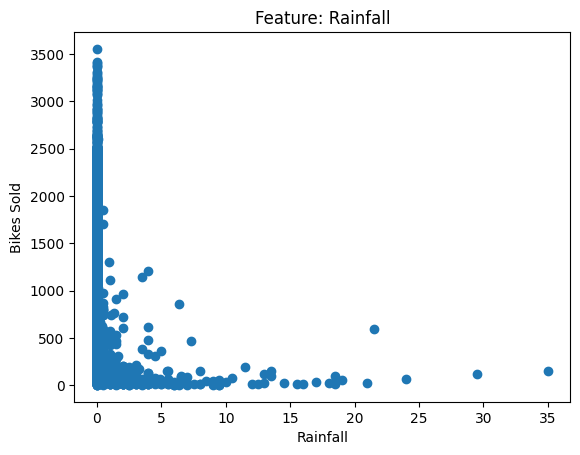

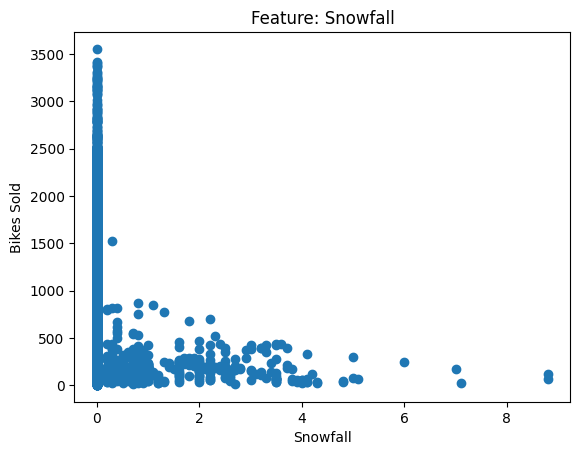

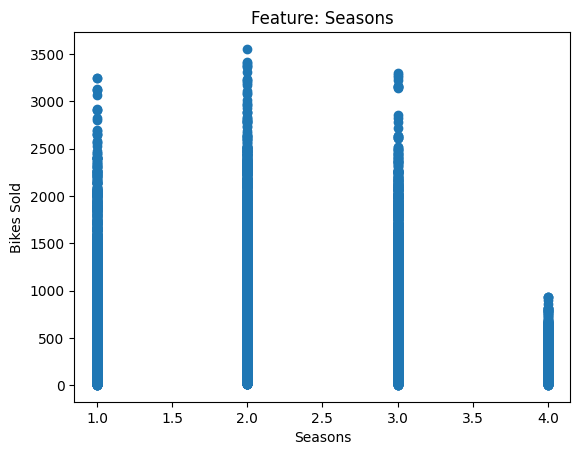

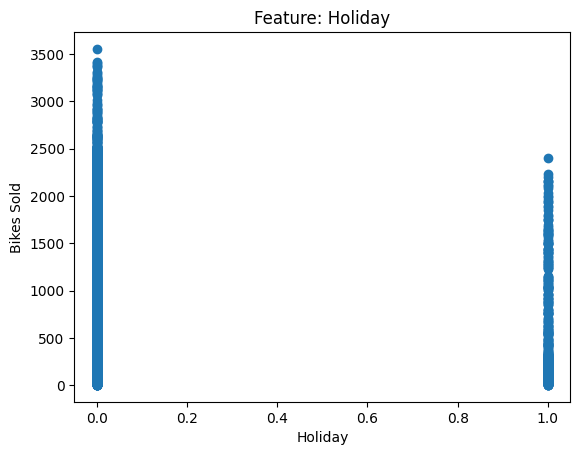

In [ ]:
for label in df.columns[1:]: # skip the first one
  plt.scatter( df[label], df["Rented Bikes"] )
  plt.title(f"Feature: {label}")
  plt.ylabel("Bikes Sold")
  plt.xlabel(label)
  plt.show()

In [ ]:
df = df.drop( ["Wind speed", "Holiday","Seasons", "Visibility"], axis = 1)  # decision to remove wind, holiday can be made based on the above graph

In [ ]:
df.head()

,Rented Bikes,Hour,Temperature,Humidity,Dew_PTemp,Solar Radiation,Rainfall,Snowfall
0,254,0,-5.2,37,-17.6,0.0,0.0,0.0
1,204,1,-5.5,38,-17.6,0.0,0.0,0.0
2,173,2,-6.0,39,-17.7,0.0,0.0,0.0
3,107,3,-6.2,40,-17.6,0.0,0.0,0.0
4,78,4,-6.0,36,-18.6,0.0,0.0,0.0


# Data Split TRAIN/TEST/VALID

In [ ]:
train, valid, test = np.split(df.sample(frac = 1), [int(0.6 * len(df)), int(0.8 * len(df))] )

In [ ]:
def get_Xy(dataframe, X_labels = None):
  if X_labels is None:
    X = dataframe[df.columns[1:]].values
  elif len(X_labels) == 1:
     X = dataframe[X_labels[0]].values.reshape(-1, 1) #whenever we have a 1d array we need to reshape it 1 1/2
  elif len(X_labels) > 1:
    X = dataframe[X_labels].values
  y = dataframe["Rented Bikes"] # 1 2/2
  return X, y

In [ ]:
X_train, y_train = get_Xy(train)
X_valid, y_valid = get_Xy(valid)
X_test, y_test = get_Xy(test)

In [ ]:
print(len(X_train)) # confirm everything is in order for the general split, thus proving general functionality
print(len(X_test))
print(len(X_valid))
print(len(X_train[0]))
print(len(X_test[0]))
print(len(X_valid[0]))

5079
1693
1693
7
7
7


# Split by X labels and test with linear Regression

In [ ]:
X_train_Temperature, y_train_Temperature = get_Xy(train, ["Temperature"])
X_valid_Temperature, y_valid_Temperature = get_Xy(valid, ["Temperature"])
X_test_Temperature, y_test_Temperature = get_Xy(test, ["Temperature"])
Temperature_regression = LinearRegression()
Temperature_regression.fit(X_train_Temperature, y_train_Temperature)

LinearRegression()

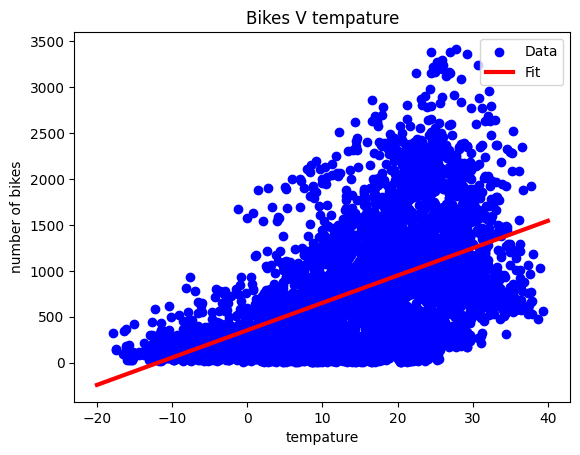

In [ ]:
plt.scatter(X_train_Temperature, y_train_Temperature, label = "Data", color = "blue")
x = tf.linspace(-20,40,100)
plt.plot(x, Temperature_regression.predict( (np.array(x).reshape(-1,1) )), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes V tempature")
plt.ylabel("number of bikes")
plt.xlabel("tempature")
plt.show()

# multiple linear regression

In [ ]:
Temperature_regression = LinearRegression()
Temperature_regression.fit(X_train_Temperature, y_train_Temperature)
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [ ]:
Temperature_regression.score(X_test_Temperature, y_test_Temperature)

0.33487052718671284

In [ ]:
regression.score(X_test, y_test)

0.5413295995831953

# Nueral Net Regression on node

In [ ]:
tempature_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None )
tempature_normalizer.adapt(X_train_Temperature.reshape(-1))

In [ ]:
tempature_nn_model = tf.keras.Sequential([
    tempature_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
tempature_nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mean_squared_error')

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
history = tempature_nn_model.fit(
    X_train_Temperature.reshape(-1), y_train_Temperature,
    verbose = 0,
    epochs = 1000,
    validation_data = (X_valid_Temperature, y_valid_Temperature)
)

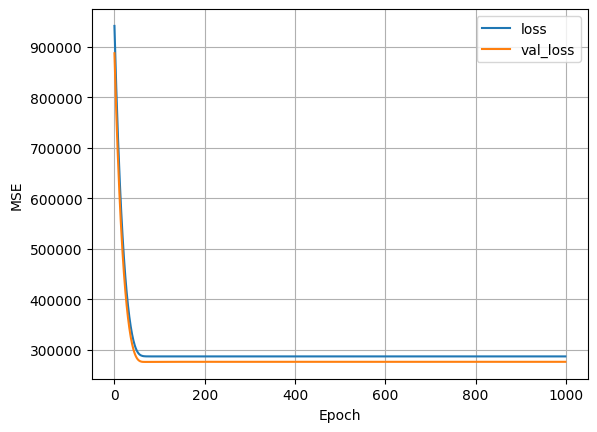

In [ ]:
plot_loss(history)

# Nueral net full

In [ ]:
normalizer = tf.keras.layers.Normalization(input_shape = (7,), axis = -1 )
normalizer.adapt(X_train)

nn_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    verbose = 0, epochs = 100
)

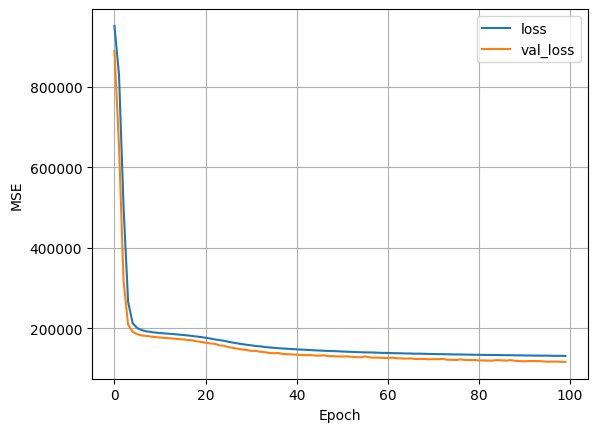

In [ ]:
plot_loss(history)

In [ ]:
# calculate MSE for nn and linear
y_pred_lr = regression.predict(X_test)
print(nn_model.predict(X_test))
y_pred_nn = nn_model.predict(X_test).flatten()

53/53 [==============================] - 1s 12ms/step
[[1247.7184 ]
 [ 605.8924 ]
 [ 710.14703]
 ...
 [ 361.76596]
 [ 450.91864]
 [1619.5486 ]]
53/53 [==============================] - 0s 2ms/step


In [ ]:
def MSE(y_pred, y_real):
  return ( np.square(y_pred - y_real).mean() )

In [ ]:
print(MSE(y_pred_lr, y_test))
print(MSE(y_pred_nn, y_test))

187937.8862912196
118431.7171972908
